In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import os
import glob
from skimage import io, color, measure
from skimage.util import img_as_float, img_as_ubyte
from skimage.segmentation import slic, mark_boundaries
import tensorflow as tf
%matplotlib inline
import time
from six.moves import xrange 

In [2]:
DATA_DIR = os.path.abspath("../Data/test-ssrbc2015/segmentation")

def get_paths(directory):
    """Gets the filenames of all sclera images in the given directory along with their 
        ground truth images
        Args:
            directory: The path to the root folder
        Output:
            images: List of paths to files containing images
            ground: List of paths to files containing corresponding ground truth images
    """
    imgs = glob.glob(DATA_DIR+"/[0-9]*/E*.jpg")
    imgs.sort()
    gt = glob.glob(DATA_DIR+"/[0-9]*/M*.jpg")
    gt.sort()
    
    # The following lines of code remove those examples whose image and ground truth 
    # sizes don't match
    images = []
    ground = []
    for i in range(len(imgs)):
        img = io.imread(imgs[i])
        g = io.imread(gt[i])
        if g.shape[0] == img.shape[0] and g.shape[1] == img.shape[1]:
            images.append(imgs[i])
            ground.append(gt[i])

    return images, ground

data, ground_truth = get_paths(DATA_DIR)

In [3]:
mean_img = pd.read_pickle('../Data/test-ssrbc2015/segmentation/mean_img.pkl')

In [11]:
PATCH_DIM = 31                          # Dimension of window used as a sample
BATCH_SIZE = 60
NUM_CLASSES = 2
SP_COMPACTNESS = 1
SP_SIGMA = 1
NUM_SP=1000

In [12]:
def inference(images, keep_prob, fc_hidden_units1=512):
    """ Builds the model as far as is required for running the network
    forward to make predictions.

    Args:
        images: Images placeholder, from inputs().
        keep_prob: Probability used for Droupout in the final Affine Layer
        fc_hidden_units1: Number of hidden neurons in final Affine layer
    Returns:
        softmax_linear: Output tensor with the computed logits.
    """
    with tf.variable_scope('h_conv1') as scope:
        weights = tf.get_variable('weights', shape=[4, 4, 3, 64], 
                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
        biases = tf.get_variable('biases', shape=[64], initializer=tf.constant_initializer(0.05))
        
        # Flattening the 3D image into a 1D array
        x_image = tf.reshape(images, [-1,PATCH_DIM,PATCH_DIM,3])
        z = tf.nn.conv2d(x_image, weights, strides=[1, 1, 1, 1], padding='VALID')
        h_conv1 = tf.nn.relu(z+biases, name=scope.name)
    with tf.variable_scope('h_conv2') as scope:
        weights = tf.get_variable('weights', shape=[4, 4, 64, 64], 
                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
        biases = tf.get_variable('biases', shape=[64], initializer=tf.constant_initializer(0.05))
        z = tf.nn.conv2d(h_conv1, weights, strides=[1, 1, 1, 1], padding='SAME')
        h_conv2 = tf.nn.relu(z+biases, name=scope.name)
    
    h_pool1 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name='h_pool1')
    
    with tf.variable_scope('h_conv3') as scope:
        weights = tf.get_variable('weights', shape=[4, 4, 64, 64], 
                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
        biases = tf.get_variable('biases', shape=[64], initializer=tf.constant_initializer(0.05))
        z = tf.nn.conv2d(h_pool1, weights, strides=[1, 1, 1, 1], padding='SAME')
        h_conv3 = tf.nn.relu(z+biases, name=scope.name)
        
    h_pool2 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name='h_pool2')
    
    with tf.variable_scope('h_fc1') as scope:
        weights = tf.get_variable('weights', shape=[7**2*64, fc_hidden_units1], 
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable('biases', shape=[fc_hidden_units1], initializer=tf.constant_initializer(0.05))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, weights) + biases, name = 'h_fc1')
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        
        
    with tf.variable_scope('h_fc2') as scope:
        weights = tf.get_variable('weights', shape=[fc_hidden_units1, NUM_CLASSES], 
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable('biases', shape=[NUM_CLASSES])
        
        logits = (tf.matmul(h_fc1_drop, weights) + biases)
    return logits

In [13]:
def placeholder_inputs(batch_size):
    """Generate placeholder variables to represent the input tensors.
    Args:
        batch_size: The batch size will be baked into both placeholders.
    Returns:
        images_placeholder: Images placeholder.
    """
    images_placeholder = tf.placeholder(tf.float32, shape=(batch_size, PATCH_DIM**2*3))
    return images_placeholder

In [14]:
def softmax(logits):
    return tf.nn.softmax(logits)

In [27]:
def nbd(image, point):
    i = point[0]
    j = point[1]
    h = int(PATCH_DIM/2)
    return image[i-h:i+h+1,j-h:j+h+1].reshape(-1)
def segment_region(segmented, row_col, segments_slic, region_id, prediction):
    a = row_col[segments_slic==region_id]
    segmented[a[:,0],a[:,1]] = prediction

In [71]:
ind = 15
image = io.imread(data[ind])
gt = img_as_float(io.imread(ground_truth[ind]))
mean_np_img = np.asarray(mean_img)

In [72]:
segments_slic = slic(image, n_segments=NUM_SP, compactness=SP_COMPACTNESS, 
                     sigma= SP_SIGMA, convert2lab = True)
segments_slic = segments_slic + 1  # So that no labelled region is 0 and ignored by regionprops
regions = measure.regionprops(segments_slic)

In [73]:
segmented = np.zeros(image.shape[:2])
segmented_prob = np.zeros(image.shape[:2])
# We will use arrays to index the image and mask later
cols, rows = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
row_col = np.stack([rows,cols], axis = 2)
region_no = 1
feed = np.zeros((BATCH_SIZE, PATCH_DIM**2*3))
feed_count = 0
pixel_count = 0
predictions = np.zeros(BATCH_SIZE)
region_count = np.zeros(BATCH_SIZE)
h = PATCH_DIM/2

begin = time.time()
start_time = time.time()

with tf.Graph().as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = placeholder_inputs(BATCH_SIZE)

    # Build a Graph that computes predictions from the inference model.
    logits = inference(images_placeholder, 1.0, 512)
    sm = softmax(logits)

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()

    # Create a session for running Ops on the Graph.
    with tf.Session() as sess:
        saver.restore(sess, '../Data/test-ssrbc2015/segmentation/model.ckpt-199')
        for r in regions:
            c = r.coords[0]
            
            pixel_count += len(r.coords)
            """
            if np.mod(pixel_count, 1000) < BATCH_SIZE:
                print "%d / %d"%(pixel_count, image.shape[0]*image.shape[1])
                current_time = time.time()
                print "Time taken - > %f" % (current_time - start_time)
                start_time = current_time
            """
            
            flag = (c[0]>h+1)&(c[0]<image.shape[0]-h-2)&(c[1]>h+1)&(c[1]<image.shape[1]-h-2)
            if not flag:
                region_no += 1
            else:
                # It is important to chose a point carefully
                # If the compactness is too less, this point maybe connected
                # to points far away
                if feed_count < BATCH_SIZE-1:
                    feed_count += 1
                    feed[feed_count] = nbd(image,c)
                    region_count[feed_count] = region_no
                else:
                    feed = feed - mean_np_img

                    # Get predictions and draw accordingly on black image    
                    predictions = sess.run([sm],
                                   feed_dict={images_placeholder: feed})
                    predictions = np.asarray(predictions).reshape(BATCH_SIZE, NUM_CLASSES)

                    predictions_prob = predictions[:,1]                 # Probability map
                    predictions = np.argmax(predictions, axis=1)    # Hard thresholding
                    map(lambda x:segment_region(segmented, row_col, segments_slic,
                                                region_count[x], predictions[x]),
                                                np.arange(feed_count))
                    map(lambda x:segment_region(segmented_prob, row_col, segments_slic,
                                                region_count[x], predictions_prob[x]),
                                                np.arange(feed_count))
                    # Reset everything after passing feed to feedforward
                    feed = np.zeros((BATCH_SIZE, PATCH_DIM**2*3))
                    predictions = np.zeros(BATCH_SIZE)
                    predictions_prob = np.zeros(BATCH_SIZE)
                    region_count = np.zeros(BATCH_SIZE)
                    feed_count = 0                
                region_no += 1

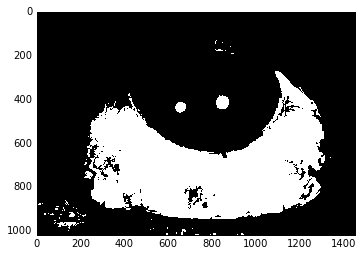

In [74]:
io.imshow(segmented)

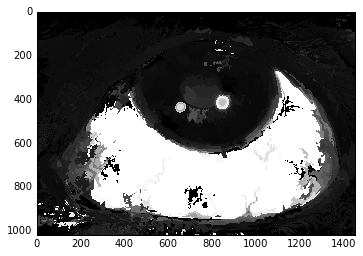

In [75]:
io.imshow(segmented_prob)

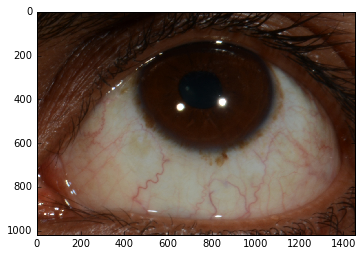

In [70]:
io.imshow(io.imread(data[15]))